Created on Friday 8 January 2021

**Group 5 - Classification**

**Gestion detection semi supervised v0**

@authors : Lilian Dulinge

This document is a notebook who try to define if a document talk about the "management range" theme. We use the same processus as V0, because we define a function who seperate documents which we are sure they are talking about management range and the documents we are sure they don't talk about about management range. With documents classifie as management range or not, we make labels at the others who are not classifie by function using semi-supervised methods. For training our models, we use the Bag Of Words given by G3 unlike to the V0 where we use the features. We have improved our word list, our function to define management ranges, our prediction algorithms for have the best predictions. We made many graphics for see our results and improve then.

# Import libraries

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from xgboost import XGBClassifier

from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix

from wordcloud import WordCloud
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Create link between drive and notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import data

In [ ]:
bow: pd.DataFrame = pd.read_json(
    '/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/g3_BOW_v1.json')

In [ ]:
data: pd.DataFrame = pd.read_csv(
    '/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/Data_With_Features_Syntax.csv')

In [ ]:
df: pd.DataFrame = pd.merge(left=bow, right=data, on='art_id')

In [ ]:
art_lemma: pd.DataFrame = pd.read_json(
    '/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/df_articles_lemma.json')

In [ ]:
df: pd.DataFrame = pd.merge(
    left=df, right=art_lemma, left_on='art_id', right_on='art_lemma_id')

In [ ]:
df_lexique: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/df_lexique_gammes_gestion.json")

In [ ]:
column_name: list = list(bow)
column_name: list = column_name[2:]

# Functions

In [ ]:
# Counts the number of words
def nb_word(text: list) -> list:
    """Documentation
    Parameters:
        text: Texts of the article

    Out (if exists):
        nb_word: Number of word in  the document
    """
    nb_words: list = []
    nb: int = 0
    
    # Browse through the different texts
    for i in text:
        # Removes special characters
        i.replace(',', ' ')
        i.replace('.', ' ')
        i.replace('!', ' ')
        i.replace('?', ' ')
        i.replace('/', ' ')
        # Creates a list with all the words present in the text
        list_words: list = i.split()
        # Counts the number of words present in the text
        nb_words.append(len(list_words))
    
    return nb_words

In [ ]:
# Count the number of time where the words in the list appear
def count_key_words(data: pd.DataFrame, l: list) -> list:
    """Documentation
    Parameters:
        data: List of articles
        l: List of word that we will check in the sentences

    Out:
        res: List where each value is the number of time where key word appear in the article
    """
    list_mot_unique: list = []
    list_mot_compose: list = []
    for elem in l:
        cpt: int = 0
        for car in elem:
            if (car == " "):
                cpt += 1
        if cpt == 0:
            list_mot_unique.append(elem)
        else:
            list_mot_compose.append(elem)
    res: list = []
    for i in tqdm(range(len(data))):
        sentence: str = data[i]
        if sentence is None:
            res.append(0)
        else:
            sentence = sentence.lower()
            sentence = sentence.split()
            t: int = 0
            for j in sentence:
                if (j in list(list_mot_unique)):
                    t = t + 1
            sentence: str = data[i]
            for elem in list_mot_compose:
                if elem in sentence:
                    t = t + 1
        res.append(t)
    
    return res

In [ ]:
# Count the number of sentence
def sentences(data: pd.DataFrame, col: str) -> list:
    """Documentation
    Parameters:
        data: Dataframe with all the data
        columns: The columns of the dataframe that we will use

    Out:
        l: List where each value is the number of sentence in a article
    """
    l: list = []
    for i in range(len(data[col])):
        sentences: str = data[col][i]
        if not isinstance(sentences, str):
            sentences: str = str(sentences)
        if (sentences is None):
            count_sentence.append(0)
        else:
            sentences = sentences.replace("..", ".")
            sentences = sentences.replace("...", ".")
            sentences = sentences.replace("!", ".")
            sentences = sentences.replace("!!", ".")
            sentences = sentences.replace("!!!", ".")
            sentences = sentences.replace("?", ".")
            sentences = sentences.replace("??", ".")
            sentences = sentences.replace("???", ".")
            sentences = sentences.replace("?!", ".")
            sentences = sentences.replace("!?", ".")
            l.append(len(sent_tokenize(sentences)))

    return l

In [ ]:
# Use to generate weighted randomness to say if a document talk about management range or not
def score_to_threshold(x: int) -> int:
    """Documentation
    Parameters:
        x: Innovation score associated with an article

    Out:
        Threshold probability used to differentiate innovative from non-innovative documents
    """

    return np.arctan(x * 100) / np.pi * 2 * 0.2 + 0.8

In [ ]:
# Function to tell if a document talk about management range or not
def gestion(data_nb1: pd.DataFrame, data_nb2: pd.DataFrame, data_nb3: pd.DataFrame, data_ratio1: pd.DataFrame, data_ratio2: pd.DataFrame, data_ratio3: pd.DataFrame) -> list:
    """Documentation
    Parameters:
        data_nb1: First column of a dataframe who describe a number of key words presents in text
        data_nb2: Second column of a dataframe who describe a number of key words presents in title
        data_nb3: Third column who describe the distinct number of key word presents in text
        data_ratio1: Linked column of data_nb1 who represents a ratio of key word apparition in text
        compared to the total number of words in text
        data_ratio2: Linked column of data_nb2 who represents a ratio of key word apparition in title
        compared to the total number of words in title
        data_ratio3: Linked column of data_nb3 who represents a ratio of distinct key word apparition in text
        compared to the total number of distinct word in text

    Out:
        list: Represents whether a document is innovative or not (i.e. yes = 1, no = 0, don't know = ?).
    """
    res: list = []
    seuil: float = 0.70

    # The higher score show document who talk about management range and the weakest show document who don't talk about management range
    for i in tqdm(range(len(data_nb1))):
        valeur = 0.5*(data_nb1[i]*data_ratio1[i]) + 0.5 * \
            (data_nb2[i]*data_ratio2[i]) + (data_nb3[i]*data_ratio3[i])
        alea: float = np.random.random()
        # We define a threshold and the document who have a score higher of this threshold take a 1 who represent management range
        if valeur > seuil:
            res.append(1)
        # Documents whith little score are consider such as they don't talk about management range take 0
        elif (valeur < seuil) & (data_nb1[i] == 0) & (data_nb2[i] == 0):
            res.append(0)
        elif (valeur < seuil) & (data_ratio1[i] < 0.0002) & (data_ratio2[i] < 0.0005):
            res.append(0)
        else:
            if valeur > seuil / 2 and alea > score_to_threshold((seuil - valeur)):
                res.append(1)
            elif valeur < seuil / 2 and alea > score_to_threshold(valeur):
                res.append(0)
            # The others have a '?' because we don't know if they talk about management range or not and we try in the rest of notebooks to create labels
            # for the documents with '?' thanks to documents who have labels
            else:
                res.append('?')

    return res

In [ ]:
# Function to see the score given by gestion function
def score_gestion(data_nb1: pd.DataFrame, data_nb2: pd.DataFrame, data_nb3: pd.DataFrame, data_ratio1: pd.DataFrame, data_ratio2: pd.DataFrame, data_ratio3: pd.DataFrame) -> list:
    """Documentation
    Parameters:
          data_nb1: First column of a dataframe who describe a number of key words presents in text
          data_nb2: Second column of a dataframe who describe a number of key words presents in title
          data_nb3: Third column who describe the distinct number of key word presents in text
          data_ratio1: Linked column of data_nb1 who represents a ratio of key word apparition in text
          compared to the total number of words in text
          data_ratio2: Linked column of data_nb2 who represents a ratio of key word apparition in title
          compared to the total number of words in title
          data_ratio3: Linked column of data_nb3 who represents a ratio of distinct key word apparition in text
          compared to the total number of distinct word in text

     Out:
          list: Represents score of management range, calculate in the function gestion
      """
    res: list = []
    for i in tqdm(range(len(data_nb1))):
        valeur: float = 0.5*(data_nb1[i]*data_ratio1[i]) + 0.5 * \
            (data_nb2[i]*data_ratio2[i]) + (data_nb3[i]*data_ratio3[i])
        res.append(valeur)
    
    return res

In [ ]:
# Count the number of distinct words in each documents
def count_words_diff(df: pd.DataFrame, list_key: list) -> list:
    """Documentation
    Parameters:
          df: Column who contain text of article
          list_key: List of key words

    Out:
          result: Lenght of all dictionary by article, who represents the number of distinct words
    """
    result: list = []
    for j in tqdm(range(len(df))):
        liste: list = df[j].split()
        dico: dict = {}
        fait: bool = False
        for i in range(len(liste)):
            try:
                if (liste[i]+' '+liste[i+1]+' '+liste[i+2]) in list_key:
                    dic(liste[i]+' '+liste[i+1]+' '+liste[i+2], dico)
                    fait = True
                else:
                    try:
                        if (liste[i]+' '+liste[i+1]) in list_key:
                            dic(liste[i]+' '+liste[i+1], dico)
                            fait = True
                    except:
                        pass
            except:
                pass
            if not fait:
                dic(liste[i], dico)
            fait = False
        result.append(len(dico))

    return result

In [ ]:
# Return a dico with all the distinct word and their numbers of appearances
def comparaison_words_diff(texte: str, list_key: list) -> dict:
    """Documentation
    Parameters:
        texte: Text of an article
        list_key: List of key words

    Out:
        dico: A dictionnary of all words presents in documents with numbers of their apparition
    """
    liste: list = texte.split()
    dico: dict = {}
    fait: bool = False
    for i in range(len(liste)):
        try:
            if (liste[i]+' '+liste[i+1]+' '+liste[i+2]) in list_key:
                dic(liste[i]+' '+liste[i+1]+' '+liste[i+2], dico)
                fait = True
            else:
                try:
                    if (liste[i]+' '+liste[i+1]) in list_key:
                        dic(liste[i]+' '+liste[i+1], dico)
                        fait = True
                except:
                    pass
        except:
            pass
        if not fait:
            dic(liste[i], dico)
        fait = False

    return dico

In [ ]:
# Count the distinct word of a list
def count_key_words_diff(liste: list) -> dict:
    """Documentation
    Parameters:
        liste: list of key words
    
    Out:
        dico: Dictionnary with all key words in list
    """
    dico: dict = {}
    for i in range(len(liste)):
        dic(liste[i], dico)
    
    return (dico)

In [ ]:
# Look up a word in a dictionary
def dic(term: str, dico: dict):
    """Documentation
    Parameters:
        term: One or set of words
        dico: Dictionary
    """
    if term in dico.keys():
        dico[term] += 1
    elif term != '':
        dico[term] = 1

In [ ]:
# Count the number of distinct key words of a list present in each text
def key_word_in_doc(df: pd.DataFrame, list_key: list) -> list:
    """Documentation
    Parameter:
        df: Column of dataframe who contains all text
        list_key: List of keys word
    """
    key_word: list = []
    for i in tqdm(range(len(df))):
        sortie: dict = comparaison_words_diff(df[i], list_key)
        liste_cle: list = []
        for cle in sortie.keys():
            liste_cle.append(cle)
        tot: int = 0
        for i in liste_cle:
            if i in (list_key.tolist()):
                tot = tot + 1
        key_word.append(tot)
    
    return (key_word)

In [ ]:
# Function to clean our data before posting them
def preprocessing(sentence: str) -> list:
    """Documentation
    Parameters:
        data: 1 column of a dataframe especially choose because we want a column who contain only text

    Out:
        liste_return: Liste of all the text of the dataframe return with preprocessing applied
    """
    stop_words: set = set(stopwords.words('french'))
    pattern: list = ['(', ')', ':', ';', ',', '&', '/',
                     '"', "'", '\n', '©', 'n°', '-', 'ludivine', 'bailly', 'christine', 'verdier', 'jstories', 'dernier', 'article',
                     'jvstories', 'fabien', 'geledan', 'dgs', 'semaine', 'avril', 'deuxieme', 'septembre',
                     'quels', 'pret', 'caroline', 'madame', 'mesdames', 'messieurs', 'monsieur', 'chere', 'martin', 'etaient',
                     'comme', 'grisot', 'lancashire', 'faire', 'plus', 'sans', 'octobre', 'frédérique', 'jean', 'mathieu',
                     'quand', 'rue', 'sylvain', 'decembre', 'blamer', 'situee', 'place',
                     'malgré', 'levée', 'étaie', 'mène', 'poursuivis', 'malgre', 'mesures', 'ère', 'malgré',
                     'journée', 'janvier', 'thématique', 'fncdg', 'autres', 'mot', 'art_content', 'jouclas',
                     'tout', 'égal', 'quelle', 'dtype', 'object', 'length', 'name', ' ob', ' publiqu ', 'ibune',
                     'créé', 'taille', 'face', 'après', 'dessous', 'deuxième', ' nt', 'dé ', 'co ',
                     'dix', 'utilisez', 'chamboule', 'postale', 'jv', 'aujourd', 'mar ',
                     'peut', 'cette', 'vols', 'finies', ' con ', ' ru', 'ifs', ' tr', 'mai',
                     'place', 'perdues', 'trois', 'lors', 'pres ', 'fpe', ' bra', ' th', 'date', 'heure',
                     'art_content_clean_without_lem', 'ans', 'épidémie', 'style', 'dark',
                     'masque', 'permis', 'toujours', 'télévision']
    if not isinstance(sentence, str):
        sentence: str = str(sentence)

    sentence: str = re.sub(r'\d', ' ', sentence)
    sentence: str = sentence.lower()

    for d in pattern:
        sentence: str = sentence.replace(d, " ")

    token_words: list = word_tokenize(sentence)
    filtre: type = [w for w in token_words if not w in stop_words]

    final_list: str = ""
    for word in filtre:
        final_list: str = final_list + word + " "
    
    return(final_list)

In [ ]:
# Generates a word cloud for an article
def wordcloud_art(text: str):
    """Documentation
    Parameters:
        text: The article that will be show on the word cloud
    """
    text: str = preprocessing(text)
    if len(text) > 0:
        wordcloud: str = WordCloud(relative_scaling=1.0,).generate(str(text))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        plt.close()
    else:
        print("The article have a size of 0.")

In [ ]:
# Generates a word cloud from a list of articles
def wordcloud_list_art(text: list):
    """Documentation
    Parameters:
        text: The list of articles that will be show on the word cloud
    """
    list_articles: str = ""
    for i in range(len(text)):
        list_articles: str = list_articles + text[0]
    wordcloud_art(text)

In [ ]:
# Visualization of a 2D point cloud with a PCA
def graph_2d(data: pd.DataFrame, prediction: list, dic_values: dict, transparency: float = 0.15):
    """Documentation
    Parameters:
        data: The data that will be show on the plot
        prediction: The prediction that will be used to make distinction bewteen the differents class on the plot
        dic_values: The signification of every values in the prediction
        transparency: The transparency of the points on the graph
    """
    # Normalisation
    components = data.shape[1]
    sc: StandardScaler = StandardScaler()
    X: ndarray = sc.fit_transform(data)

    # PCA
    pca: PCA = PCA(n_components=components)
    X: ndarray = pca.fit_transform(X)

    # Chart
    plt.title('Titre')
    for name_modal in dic_values:
        plt.scatter(X[prediction == dic_values[name_modal], 0], X[prediction ==
                                                                  dic_values[name_modal], 1], alpha=transparency, label=name_modal)
    plt.legend()

In [ ]:
# Visualization of a 3D point cloud with a PCA
def graph_3d(data: pd.DataFrame, prediction: list, axes=(0, 1, 2), opacity: int = 1):
    """Documentation
    Parameters:
        data: The data that will be show on the plot
        prediction: The prediction that will be used to make distinction bewteen the differents class on the plot
        axes: Axes to plot
        opacity: The transparency of the points on the graph
    """
    # Normalisation
    components = data.shape[1]
    sc: StandardScaler = StandardScaler()
    X: ndarray = sc.fit_transform(data)

    # PCA
    pca: PCA = PCA(n_components=components)
    X: ndarray = pca.fit_transform(X)

    # Chart
    data_plot: pd.DataFrame = pd.DataFrame(X)
    data_plot["prediction"]: Series = prediction
    fig: Figure = px.scatter_3d(
        data_plot, x=0, y=1, z=2, color='prediction', opacity=0.5)
    fig.show()

Create all features for search documents who talk about management range

In [ ]:
df["nb_key_words"]: pd.DataFrame = count_key_words(
    df["art_lemma"], df_lexique["key_words_lemma"])
df["nb_key_words_title"]: pd.DataFrame = count_key_words(
    df["art_title"], df_lexique["key_words_lemma"])
df["nb_words"]: pd.DataFrame = nb_word(df['art_content_clean_without_lem'])
df["nb_words_title"]: pd.DataFrame = nb_word(df['art_title'])
df["nb_sentences"]: pd.DataFrame = sentences(
    df, 'art_content_clean_without_lem')
df["average_word_sentence"]: pd.DataFrame = df["nb_words"] / df["nb_sentences"]
df["ratio_word_title_on_word"]: pd.DataFrame = df["nb_words_title"] / df["nb_words"]
df['ratio_key_words']: pd.DataFrame = df['nb_key_words']/df['nb_words']
df['ratio_key_words']: pd.DataFrame = df['ratio_key_words'].fillna(0)
df['ratio_key_sentences']: pd.DataFrame = df['nb_key_words']/df['nb_sentences']
df['ratio_key_sentences']: pd.DataFrame = df['ratio_key_sentences'].fillna(0)
df['ratio_key_word_title']: pd.DataFrame = df['nb_key_words_title'] / \
    df['nb_words_title']
df['ratio_key_word_title']: pd.DataFrame = df['ratio_key_word_title'].fillna(0)
df['word_key_diff']: pd.DataFrame = key_word_in_doc(
    df['art_lemma'], df_lexique['key_words_lemma'])
df['word_diff']: pd.DataFrame = count_words_diff(
    df['art_lemma'], df_lexique['key_words_lemma'])
df['ratio_key_word_diff']: pd.DataFrame = df['word_key_diff'] / df['word_diff']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [ ]:
df['gestion_detection']: pd.DataFrame = gestion(df['nb_key_words'], df['nb_key_words_title'],
                                                df['word_key_diff'], df['ratio_key_words'], df['ratio_key_word_title'], df['ratio_key_word_diff'])
df['score_gestion']: pd.DataFrame = score_gestion(df['nb_key_words'], df['nb_key_words_title'],
                                                  df['word_key_diff'], df['ratio_key_words'], df['ratio_key_word_title'], df['ratio_key_word_diff'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



## Understand our distribution of labels

In [ ]:
df['gestion_detection'].value_counts()

?    5777
0     975
1     781
Name: gestion_detection, dtype: int64

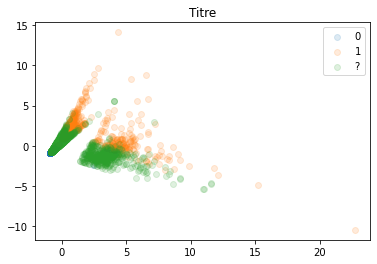

In [ ]:
# See our initial points
graph_2d(df[['nb_key_words', 'nb_key_words_title', 'ratio_key_words',
             'ratio_key_word_title']], df["gestion_detection"], dic_values={0: 0, 1: 1, "?": "?"})

In [ ]:
# Function useful for create histogramme
def count_elements(seq) -> dict:
    """Documentation
    Parameters:
        seq: Column Dataframe : 'score_gestion'

    Out:
        hist: Dictionary
    """
    hist: dict = {}
    for i in range(len(seq)):
        hist[seq[i]] = hist.get(i, 0) + 1

    return hist

In [ ]:
dictio: dict = count_elements(df['score_gestion'])

Text(0.5, 1.0, 'score repartiton')

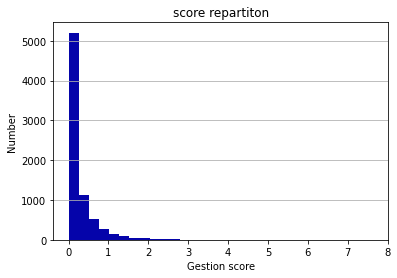

In [ ]:
n, bins, patches = plt.hist(x=df['score_gestion'], bins=30, color='#0504aa')
plt.grid(axis='y')
plt.xlabel('Gestion score')
plt.ylabel('Number')
plt.title('score repartiton')

Text(0.5, 1.0, 'score repartiton')

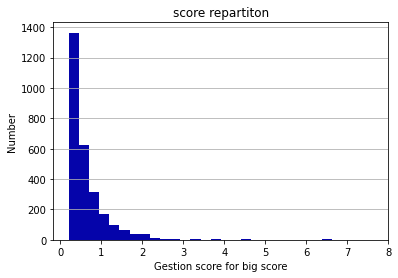

In [ ]:
df_histo: pd.DataFrame = df[df['score_gestion'] > 0.2]

n, bins, patches = plt.hist(
    x=df_histo['score_gestion'], bins=30, color='#0504aa')
plt.grid(axis='y')
plt.xlabel('Gestion score for big score')
plt.ylabel('Number')
plt.title('score repartiton')

Text(0.5, 1.0, 'score repartiton')

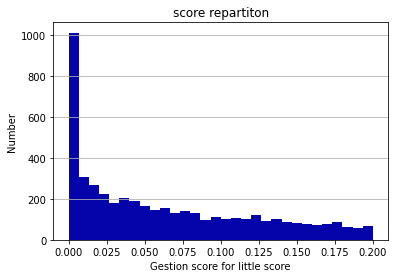

In [ ]:
df_histo: pd.DataFrame = df[df['score_gestion'] < 0.2]

n, bins, patches = plt.hist(
    x=df_histo['score_gestion'], bins=30, color='#0504aa')
plt.grid(axis='y')
plt.xlabel('Gestion score for little score')
plt.ylabel('Number')
plt.title('score repartiton')

# Prepare Data

In [ ]:
df: pd.DataFrame = df.sample(frac=1, random_state=15).reset_index(drop=True)

In [ ]:
df['index']: pd.DataFrame = df.index

In [ ]:
var_utile: pd.DataFrame = df[column_name]
var_utile: pd.DataFrame = pd.concat(
    [var_utile, df['gestion_detection']], axis=1)

In [ ]:
tout: pd.DataFrame = var_utile[var_utile['gestion_detection'] != '?']
unlabeled: pd.DataFrame = var_utile[var_utile['gestion_detection'] == '?']

In [ ]:
print(str(len(df)), str(len(tout)), str(len(unlabeled)))

7533 1756 5777


In [ ]:
trainData, testData = train_test_split(tout,
                                       test_size=0.1)

In [ ]:
X_train: pd.DataFrame = trainData.drop('gestion_detection', axis=1)
y_train: pd.DataFrame = trainData.gestion_detection

X_unlabeled: pd.DataFrame = unlabeled.drop('gestion_detection', axis=1)

X_test: pd.DataFrame = testData.drop('gestion_detection', axis=1)
y_test: pd.DataFrame = testData.gestion_detection

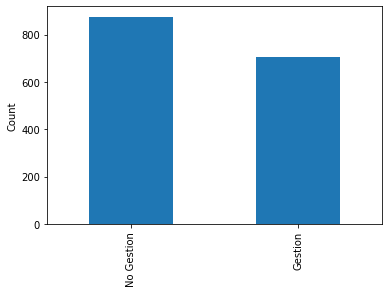

In [ ]:
y_train.value_counts().plot(kind='bar')
plt.xticks([0, 1], ['No Gestion', 'Gestion'])
plt.ylabel('Count')

In [ ]:
y_train: pd.DataFrame = pd.to_numeric(y_train)
y_test: pd.DataFrame = pd.to_numeric(y_test)

# Implementation of the learning phase

## First classifier

### Choose the best classifier for these data

Train f1 Score: 0.9992902767920511
Test f1 Score: 0.9934640522875817


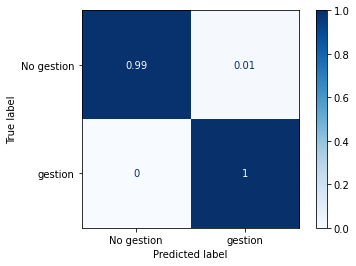

In [ ]:
# Logistic Regression
log: LogisticRegression = LogisticRegression(penalty='l1', solver='liblinear')

log.fit(X_train, y_train)
y_hat_test: np.ndarray = log.predict(X_test)
y_hat_train: np.ndarray = log.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(log, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No gestion', 'gestion'])

Train f1 Score: 1.0
Test f1 Score: 0.918918918918919


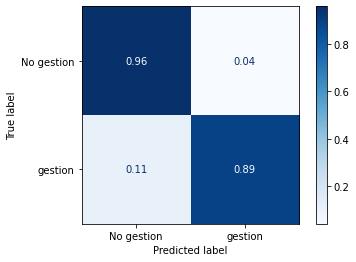

In [ ]:
# Tree Decision classifier
tree: DecisionTreeClassifier = DecisionTreeClassifier(random_state=0)

tree.fit(X_train, y_train)
y_hat_test: np.ndarray = tree.predict(X_test)
y_hat_train: np.ndarray = tree.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(tree, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No gestion', 'gestion'])

Train f1 Score: 1.0
Test f1 Score: 0.9316770186335402


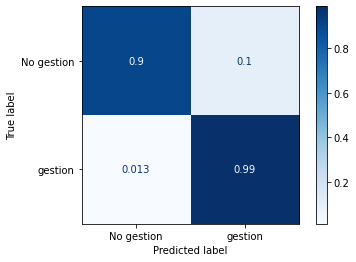

In [ ]:
# Extra tree classifier
extra_tree: ExtraTreesClassifier = ExtraTreesClassifier(
    n_estimators=100, random_state=0)

extra_tree.fit(X_train, y_train)
y_hat_test: np.ndarray = extra_tree.predict(X_test)
y_hat_train: np.ndarray = extra_tree.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(extra_tree, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No gestion', 'gestion'])

Train f1 Score: 0.8233413269384493
Test f1 Score: 0.7518796992481203


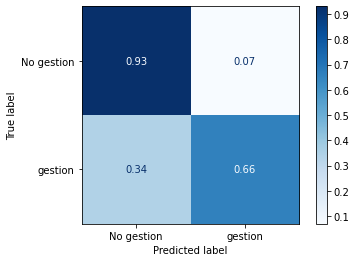

In [ ]:
# Random Forest
forest: RandomForestClassifier = RandomForestClassifier(
    max_depth=2, random_state=0)

forest.fit(X_train, y_train)
y_hat_test: np.ndarray = forest.predict(X_test)
y_hat_train: np.ndarray = forest.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(forest, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No gestion', 'gestion'])

Train f1 Score: 0.9914163090128755
Test f1 Score: 0.9668874172185431


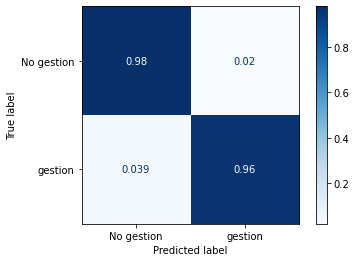

In [ ]:
# XGBoost
xgb: XGBClassifier = XGBClassifier()

xgb.fit(X_train, y_train)
y_hat_test: np.ndarray = xgb.predict(X_test)
y_hat_train: np.ndarray = xgb.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(xgb, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No gestion', 'gestion'])

Train f1 Score: 0.8605962933118453
Test f1 Score: 0.8217054263565892


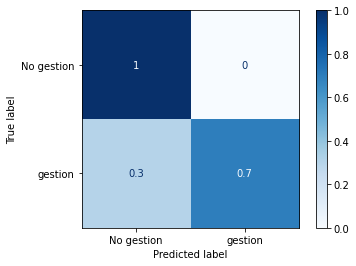

In [ ]:
# k Neighbors Classifier
knn: KNeighborsClassifier = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_hat_test: np.ndarray = knn.predict(X_test)
y_hat_train: np.ndarray = knn.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(knn, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No gestion', 'gestion'])

rbf :
Train f1 Score: 0.94351630867144
Test f1 Score: 0.9333333333333333

linear :
Train f1 Score: 0.94770206022187
Test f1 Score: 0.93687707641196

poly :
Train f1 Score: 0.8111011638316921
Test f1 Score: 0.7692307692307693

sigmoid :
Train f1 Score: 0.5902366863905325
Test f1 Score: 0.6178343949044586



Train f1 Score: 1.0
Test f1 Score: 0.9801324503311258


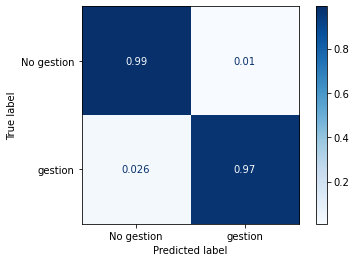

In [ ]:
# Support vector machine
svc = svm.SVC(C=4, kernel='linear', probability=True)

svc.fit(X_train, y_train)
y_hat_test: np.ndarray = svc.predict(X_test)
y_hat_train: np.ndarray = svc.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(svc, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No gestion', 'gestion'])

Train f1 Score: 0.9971590909090908
Test f1 Score: 0.869047619047619


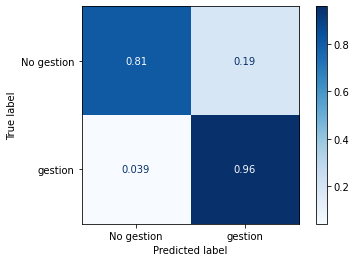

In [ ]:
# SGD classifier
clf = make_pipeline(StandardScaler(),
                    SGDClassifier(max_iter=1000, tol=1e-3, loss='log'))

clf.fit(X_train, y_train)
y_hat_test: np.ndarray = clf.predict(X_test)
y_hat_train: np.ndarray = clf.predict(X_train)

train_f1: float = f1_score(y_train, y_hat_train)
test_f1: float = f1_score(y_test, y_hat_test)

print(f"Train f1 Score: {train_f1}")
print(f"Test f1 Score: {test_f1}")

# The beautiful checkerboard
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No gestion', 'gestion'])

In [ ]:
# Generate probabilities for each prediction
xgb.predict_proba(X_test)

array([[2.24858522e-03, 9.97751415e-01],
       [7.04878569e-03, 9.92951214e-01],
       [1.03068352e-03, 9.98969316e-01],
       [9.71475780e-01, 2.85242330e-02],
       [9.82550859e-01, 1.74491536e-02],
       [9.24247444e-01, 7.57525489e-02],
       [9.82550859e-01, 1.74491536e-02],
       [9.65804219e-01, 3.41957547e-02],
       [9.82550859e-01, 1.74491536e-02],
       [3.60364914e-02, 9.63963509e-01],
       [9.82550859e-01, 1.74491536e-02],
       [8.27535152e-01, 1.72464833e-01],
       [1.30605698e-02, 9.86939430e-01],
       [5.40705919e-02, 9.45929408e-01],
       [9.80973721e-01, 1.90262850e-02],
       [9.82550859e-01, 1.74491536e-02],
       [9.71774757e-01, 2.82252189e-02],
       [3.16023827e-03, 9.96839762e-01],
       [8.22371244e-02, 9.17762876e-01],
       [9.78912771e-01, 2.10872181e-02],
       [1.31587803e-01, 8.68412197e-01],
       [9.50419903e-03, 9.90495801e-01],
       [8.94785345e-01, 1.05214648e-01],
       [9.78253245e-01, 2.17467807e-02],
       [8.811646

### After decision, train first classifier

we classify all the data for which the model is more than 99% certain of its response. We use 2 differents models to classifie with 99% safety and a last model differents of the first two with 50% of safety for classifie all the rest of data

In [ ]:
# Initiate iteration counter
iterations: int = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s: list = []
test_f1s: list = []
pseudo_labels: list = []

# Assign value to initiate while loop
high_prob: list = [1]

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:

    # Fit classifier and make train/test predictions
    xgb: XGBClassifier = XGBClassifier()
    xgb.fit(X_train, y_train)
    y_hat_train: np.ndarray = xgb.predict(X_train)
    y_hat_test: np.ndarray = xgb.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1: float = f1_score(y_train, y_hat_train)
    test_f1: float = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

    if (len(X_unlabeled) > 0):
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs: np.ndarray = xgb.predict_proba(X_unlabeled)
        preds: np.ndarray = xgb.predict(X_unlabeled)
        prob_0: list = pred_probs[:, 0]
        prob_1: list = pred_probs[:, 1]

        # Store predictions and probabilities in dataframe
        df_pred_prob: pd.DataFrame = pd.DataFrame([])
        df_pred_prob['preds']: pd.DataFrame = preds
        df_pred_prob['prob_0']: pd.DataFrame = prob_0
        df_pred_prob['prob_1']: pd.DataFrame = prob_1
        df_pred_prob.index: pd.DataFrame = X_unlabeled.index

        # Separate predictions with > 99% probability
        high_prob: pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                                             df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                                            axis=0)

        print(f"{len(high_prob)} high-probability predictions added to training data.")

        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train: pd.DataFrame = pd.concat(
            [X_train, X_unlabeled.loc[high_prob.index]], axis=0)
        y_train: pd.DataFrame = pd.concat([y_train, high_prob.preds])

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabeled: pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
        print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")

        # Update iteration counter
        iterations += 1
    else:
        high_prob: list = []
        print(f'end of process.')

Iteration 0
Train f1: 0.9914163090128755
Test f1: 0.9668874172185431
Now predicting labels for unlabeled data...
303 high-probability predictions added to training data.
5474 unlabeled instances remaining.

Iteration 1
Train f1: 0.9950149551345963
Test f1: 0.9668874172185431
Now predicting labels for unlabeled data...
96 high-probability predictions added to training data.
5378 unlabeled instances remaining.

Iteration 2
Train f1: 0.9940882219190542
Test f1: 0.9668874172185431
Now predicting labels for unlabeled data...
31 high-probability predictions added to training data.
5347 unlabeled instances remaining.

Iteration 3
Train f1: 0.9946949602122016
Test f1: 0.9673202614379085
Now predicting labels for unlabeled data...
25 high-probability predictions added to training data.
5322 unlabeled instances remaining.

Iteration 4
Train f1: 0.9948051948051947
Test f1: 0.9605263157894737
Now predicting labels for unlabeled data...
30 high-probability predictions added to training data.
5292 u

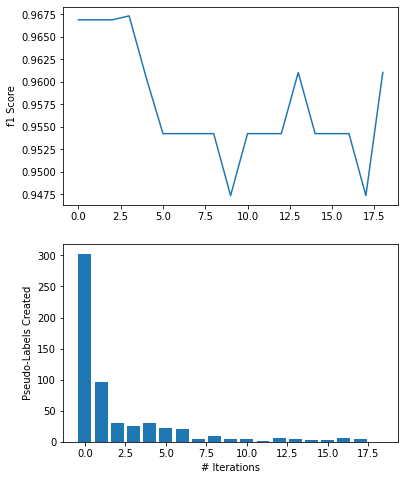

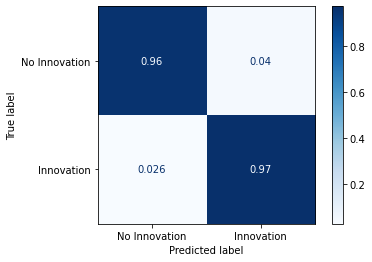

In [ ]:
# Plot f1 scores and number of pseudo-labels added for all iterations
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))
ax1.plot(range(iterations), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations')

# View confusion matrix after self-training
plot_confusion_matrix(xgb, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No Innovation', 'Innovation'])

## Train Second classifier for the last unlabelled data

In [ ]:
# Initiate iteration counter
iterations: int = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s: list = []
test_f1s: list = []
pseudo_labels: list = []

# Assign value to initiate while loop
high_prob: list = [1]

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:

    # Fit classifier and make train/test predictions
    log: LogisticRegression = LogisticRegression(
        penalty='l1', solver='liblinear')
    log.fit(X_train, y_train)
    y_hat_train: np.ndarray = log.predict(X_train)
    y_hat_test: np.ndarray = log.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1: float = f1_score(y_train, y_hat_train)
    test_f1: float = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

    if (len(X_unlabeled) > 0):
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs: np.ndarray = log.predict_proba(X_unlabeled)
        preds: np.ndarray = log.predict(X_unlabeled)
        prob_0: list = pred_probs[:, 0]
        prob_1: list = pred_probs[:, 1]

        # Store predictions and probabilities in dataframe
        df_pred_prob: pd.DataFrame = pd.DataFrame([])
        df_pred_prob['preds']: pd.DataFrame = preds
        df_pred_prob['prob_0']: pd.DataFrame = prob_0
        df_pred_prob['prob_1']: pd.DataFrame = prob_1
        df_pred_prob.index: pd.DataFrame = X_unlabeled.index

        # Separate predictions with > 99% probability
        high_prob: pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                                             df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                                            axis=0)

        print(f"{len(high_prob)} high-probability predictions added to training data.")

        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train: pd.DataFrame = pd.concat(
            [X_train, X_unlabeled.loc[high_prob.index]], axis=0)
        y_train: pd.DataFrame = pd.concat([y_train, high_prob.preds])

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabeled: pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
        print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")

        # Update iteration counter
        iterations += 1
    else:
        high_prob: list = []
        print(f'end of process.')

Iteration 0
Train f1: 0.9996101364522417
Test f1: 0.9934640522875817
Now predicting labels for unlabeled data...
1516 high-probability predictions added to training data.
3683 unlabeled instances remaining.

Iteration 1
Train f1: 0.9997489329651017
Test f1: 0.9934640522875817
Now predicting labels for unlabeled data...
423 high-probability predictions added to training data.
3260 unlabeled instances remaining.

Iteration 2
Train f1: 0.9997576932396414
Test f1: 0.9934640522875817
Now predicting labels for unlabeled data...
232 high-probability predictions added to training data.
3028 unlabeled instances remaining.

Iteration 3
Train f1: 0.999761620977354
Test f1: 0.9934640522875817
Now predicting labels for unlabeled data...
116 high-probability predictions added to training data.
2912 unlabeled instances remaining.

Iteration 4
Train f1: 0.9997639839509086
Test f1: 0.9934640522875817
Now predicting labels for unlabeled data...
70 high-probability predictions added to training data.
284

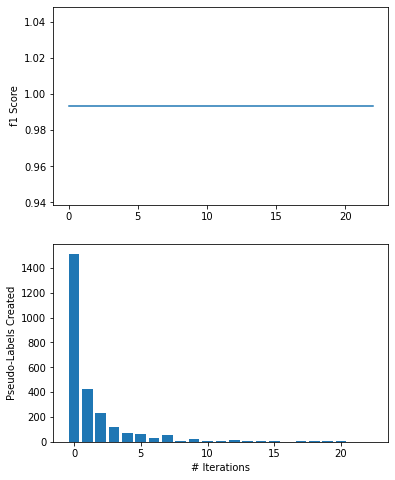

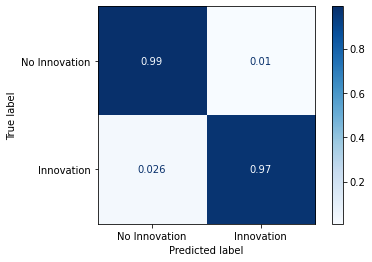

In [ ]:
# Plot f1 scores and number of pseudo-labels added for all iterations
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))
ax1.plot(range(iterations), test_f1s)
ax1.set_ylabel('f1 Score')
ax2.bar(x=range(iterations), height=pseudo_labels)
ax2.set_ylabel('Pseudo-Labels Created')
ax2.set_xlabel('# Iterations')

# View confusion matrix after self-training
plot_confusion_matrix(svc, X_test, y_test, cmap='Blues', normalize='true',
                      display_labels=['No Innovation', 'Innovation'])

## If needed, third classifier

In [ ]:
# Initiate iteration counter
iterations: int = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s: list = []
test_f1s: list = []
pseudo_labels: list = []

# Assign value to initiate while loop
high_prob: list = [1]

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:

    # Fit classifier and make train/test predictions
    svc = svm.SVC(C=4, kernel='linear', probability=True)
    svc.fit(X_train, y_train)
    y_hat_train: np.ndarray = svc.predict(X_train)
    y_hat_test: np.ndarray = svc.predict(X_test)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1: float = f1_score(y_train, y_hat_train)
    test_f1: float = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

    if (len(X_unlabeled) > 0):
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs: np.ndarray = svc.predict_proba(X_unlabeled)
        preds: np.ndarray = svc.predict(X_unlabeled)
        prob_0: list = pred_probs[:, 0]
        prob_1: list = pred_probs[:, 1]

        # Store predictions and probabilities in dataframe
        df_pred_prob: pd.DataFrame = pd.DataFrame([])
        df_pred_prob['preds']: pd.DataFrame = preds
        df_pred_prob['prob_0']: pd.DataFrame = prob_0
        df_pred_prob['prob_1']: pd.DataFrame = prob_1
        df_pred_prob.index: pd.DataFrame = X_unlabeled.index

        # Separate predictions with > 60% probability
        high_prob: pd.DataFrame = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.50],
                                             df_pred_prob.loc[df_pred_prob['prob_1'] > 0.50]],
                                            axis=0)

        print(f"{len(high_prob)} high-probability predictions added to training data.")

        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train: pd.DataFrame = pd.concat(
            [X_train, X_unlabeled.loc[high_prob.index]], axis=0)
        y_train: pd.DataFrame = pd.concat([y_train, high_prob.preds])

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabeled: pd.DataFrame = X_unlabeled.drop(index=high_prob.index)
        print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")

        # Update iteration counter
        iterations += 1
    else:
        high_prob: list = []
        print(f'end of process.')

Iteration 0
Train f1: 1.0
Test f1: 0.9934640522875817
Now predicting labels for unlabeled data...
2587 high-probability predictions added to training data.
16 unlabeled instances remaining.

Iteration 1
Train f1: 1.0
Test f1: 0.9736842105263158
Now predicting labels for unlabeled data...
16 high-probability predictions added to training data.
0 unlabeled instances remaining.

Iteration 2
Train f1: 1.0
Test f1: 0.9736842105263158
end of process.


##Recuperate data, analyse results and export results


In [ ]:
X_test['gestion_detection']: pd.DataFrame = y_test
test_end: pd.DataFrame = X_test

In [ ]:
X_train['gestion_detection']: pd.DataFrame = y_train
train_end: pd.DataFrame = X_train

In [ ]:
final: pd.DataFrame = pd.concat([train_end, test_end])

In [ ]:
final['index']: pd.DataFrame = final.index

In [ ]:
final: pd.DataFrame = final[['index', 'gestion_detection']]

In [ ]:
df_final: pd.DataFrame = pd.merge(
    left=df, right=final, left_on='index', right_on='index')

In [ ]:
data_acp: pd.DataFrame = df_final[[
    'nb_key_words', 'nb_key_words_title', 'ratio_key_words', 'ratio_key_word_title']]
y: pd.DataFrame = df_final['gestion_detection_y']
dic_values: dict = {"Gestion": 1, "No Gestion": 0}

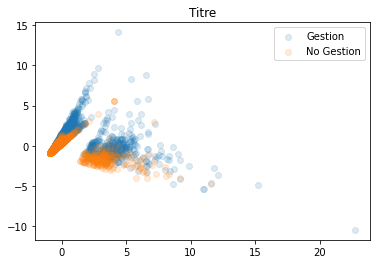

In [ ]:
# Graph 2D for see predictions
graph_2d(data_acp, y, dic_values)

In [ ]:
# Graph 3D for see predictions
graph_3d(data_acp, y, dic_values)

In [ ]:
df_final: pd.DataFrame = df_final[['art_id', 'gestion_detection_y']]

In [ ]:
df_final: pd.DataFrame = df_final.rename(
    columns={'gestion_detection_y': 'gamme_gestion'})

In [ ]:
df_final.to_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/Res_gestion_semi_supervised_V1_boost.json")

# Results analysis

In [ ]:
data0: pd.DataFrame = pd.read_csv(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Input/Data_With_Features_Syntax.csv")

gestion: pd.DataFrame = pd.read_json(
    "/content/drive/MyDrive/G5 Inter-Promo 2021/Données/Output/Innovation/Res_gestion_semi_supervised_V1_boost.json")

df2: pd.DataFrame = pd.merge(left=data0, right=gestion, on='art_id')

df_gestion: pd.DataFrame = df2[df2['gamme_gestion'] == 1]
df_gestion: pd.DataFrame = df_gestion.reset_index()

df_non_gestion: pd.DataFrame = df2[df2['gamme_gestion'] == 0]
df_non_gestion: pd.DataFrame = df_non_gestion.reset_index()

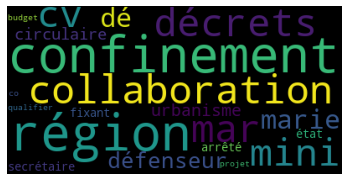

In [ ]:
# Word cloud of documents classifie as management range with bag of words
wordcloud_list_art(df_gestion.loc[:len(df_gestion), "art_content"])

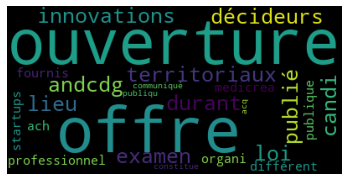

In [ ]:
# Word cloud of documents classifie as no management range with bag of words
wordcloud_list_art(df_non_gestion.loc[:len(df_non_gestion), "art_content"])